# Bank Transaction Category Predictive Model

## Import Libraries

In [109]:
# import data 


## Load and Understand Data

In [110]:
import pandas as pd
import re

bank_transactions = pd.read_csv("bank_transaction.csv")
user_profiles = pd.read_csv("user_profile.csv")

print("Bank Transaction Data : \n", bank_transactions.head().to_string())
print("User Profile Data     : \n", user_profiles.head().to_string())

Bank Transaction Data : 
    client_id  bank_id  account_id  txn_id             txn_date                                                                                                                       description  amount         category
0          1        1           1       4  2023-09-29 00:00:00                                                                           Earnin           PAYMENT                 Donatas Danyal    20.0            Loans
1          1        1           1       3  2023-08-14 00:00:00                                                       ONLINE TRANSFER FROM NDonatas DanyalDA O CARSON BUSINESS CHECKING 1216 1216    25.0  Transfer Credit
2          1        1           1       5  2023-09-25 00:00:00  MONEY TRANSFER                          AUTHORIZED ON   09/25 FROM Earnin CDAEJ_B                     CA  S583269001208168   111    20.0            Loans
3          1        1           2       1  2023-06-02 00:00:00                                        

In [111]:
# display information on imported data
print("Bank Transaction Info :")
print(bank_transactions.info())
print()

print("User Profile Info :")
print(user_profiles.info())

Bank Transaction Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258779 entries, 0 to 258778
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   client_id    258779 non-null  int64  
 1   bank_id      258779 non-null  int64  
 2   account_id   258779 non-null  int64  
 3   txn_id       258779 non-null  int64  
 4   txn_date     258779 non-null  object 
 5   description  258779 non-null  object 
 6   amount       258779 non-null  float64
 7   category     258522 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 15.8+ MB
None

User Profile Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   CLIENT_ID                      1000 non-null   int64
 1   IS_INTERESTED_INVESTMENT       1000 non-null   bool 
 2   IS_IN

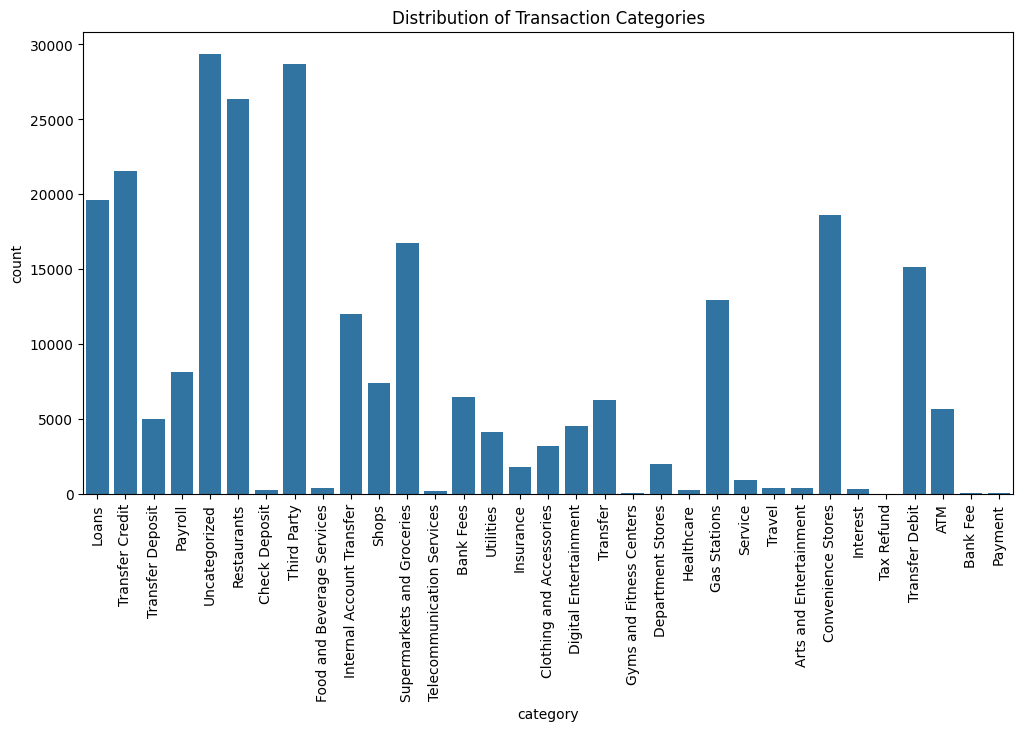

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of transaction categories
plt.figure(figsize=(12, 6))
sns.countplot(data=bank_transactions, x='category')
plt.title('Distribution of Transaction Categories')
plt.xticks(rotation=90)
plt.show()
    


# Step 1 : Data Preprocessing

## Drop NaN Value

In [113]:
# Check the count of NaN values in each column
nan_counts = bank_transactions.isna().sum()

print("NaN counts for each column in 'bank_transactions':")
print(nan_counts)

# Show the count of rows before and after dropping
print(f"\nTotal rows before dropping : {len(bank_transactions)}")

# Drop rows with NaN values in the 'description' column
bank_transactions = bank_transactions.dropna(subset=['category'])

print(f"Total rows after dropping  : {len(bank_transactions)}")

NaN counts for each column in 'bank_transactions':
client_id        0
bank_id          0
account_id       0
txn_id           0
txn_date         0
description      0
amount           0
category       257
dtype: int64

Total rows before dropping : 258779
Total rows after dropping  : 258522


### Check Unique Category list

In [114]:
# List of expected categories : 'category'

# Arts and Entertainment
# ATM
# Bank Fees
# Check Deposit
# Clothing and Accessories
# Convenience Stores
# Department Stores
# Digital Entertainment
# Food and Beverage Services
# Gas Stations
# Gyms and Fitness Centers
# Healthcare
# Insurance
# Interest
# Internal Account Transfer
# Loans
# Payment
# Payroll
# Restaurants
# Service
# Shops
# Supermarkets and Groceries
# Tax Refund
# Telecommunication Services
# Third Party
# Transfer Credit
# Transfer Debit
# Transfer Deposit
# Travel
# Utilities

# Get the unique categories and sort them
unique_categories = sorted(bank_transactions['category'].unique())

# Print the unique categories in ascending order
print("Unique categories in ascending order:")
for i, category in enumerate(unique_categories, 1):
    print(f"{i}. {category}")

Unique categories in ascending order:
1. ATM
2. Arts and Entertainment
3. Bank Fee
4. Bank Fees
5. Check Deposit
6. Clothing and Accessories
7. Convenience Stores
8. Department Stores
9. Digital Entertainment
10. Food and Beverage Services
11. Gas Stations
12. Gyms and Fitness Centers
13. Healthcare
14. Insurance
15. Interest
16. Internal Account Transfer
17. Loans
18. Payment
19. Payroll
20. Restaurants
21. Service
22. Shops
23. Supermarkets and Groceries
24. Tax Refund
25. Telecommunication Services
26. Third Party
27. Transfer
28. Transfer Credit
29. Transfer Debit
30. Transfer Deposit
31. Travel
32. Uncategorized
33. Utilities


In [115]:
# Sample 20 rows for each category
sampled_data = bank_transactions.groupby('category', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 20), random_state=1)
)[['description', 'category']]

# Display the sampled data
print(sampled_data.to_string())

                                                                                                                                                                                                                                                            description                    category
125891                                                                                                                                                                                              BKOFAMMaryse Hemant ATM 09/09 #3168 WITHDRWL MIDDLESEX BALTIMORE MD                         ATM
135609                                                                                                                                                                                                                          NON-CHASE ATM WITHDRAW 387631 1036 Whit                         ATM
140121                                                                                                                      

C:\Users\USER\AppData\Local\Temp\ipykernel_21352\2551211389.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = bank_transactions.groupby('category', group_keys=False).apply(


In [123]:
# According to the data_dictionary only 30 unique category are stated
# Notice : that there're similarity between Bank Fee and Bank Fees which typo may occur, a merge is suitable
# Notice : Transfer can't be calssify as Debit or Credit or Deposit, hence to be removed to avoid misunderstanding
# Notice : Uncategorized are not eligible for training and testing due to lack of guidance, hence to be removed

# Print total length before any changes
total_length_before = len(bank_transactions)
print(f"Total length before changes : {total_length_before}")

# Count of rows for specific categories before changes
bank_fee_count_before = bank_transactions[bank_transactions['category'] == 'Bank Fee'].shape[0]
bank_fees_count_before = bank_transactions[bank_transactions['category'] == 'Bank Fees'].shape[0]
transfer_count_before = bank_transactions[bank_transactions['category'] == 'Transfer'].shape[0]
uncategorized_count_before = bank_transactions[bank_transactions['category'] == 'Uncategorized'].shape[0]

print(f"\nCount of 'Bank Fee' before changes      : {bank_fee_count_before}")
print(f"Count of 'Bank Fees' before changes     : {bank_fees_count_before}")
print(f"Count of 'Transfer' before changes      : {transfer_count_before}")
print(f"Count of 'Uncategorized' before changes : {uncategorized_count_before}")

# Rename 'Bank Fee' to 'Bank Fees'
bank_transactions['category'] = bank_transactions['category'].replace('Bank Fee', 'Bank Fees')

# Remove rows where category is 'Transfer' or 'Uncategorized'
bank_transactions = bank_transactions[~bank_transactions['category'].isin(['Transfer', 'Uncategorized'])]

# Reset index after filtering
bank_transactions = bank_transactions.reset_index(drop=True)

# Print total length after changes
total_length_after = len(bank_transactions)
print(f"\nTotal length after changes : {total_length_after}")

# Count of rows for 'Bank Fees' after changes
bank_fees_count_after = bank_transactions[bank_transactions['category'] == 'Bank Fees'].shape[0]

# Calculate number of rows removed
rows_removed = total_length_before - total_length_after

print(f"Count of 'Bank Fees' after changes : {bank_fees_count_after}")
print(f"Number of rows removed             : {rows_removed}")


# Get the unique categories and sort them
unique_categories = sorted(bank_transactions['category'].unique())

# Print the unique categories in ascending order
print("\nUnique categories in ascending order:")
for i, category in enumerate(unique_categories, 1):
    print(f"{i}. {category}")


Total length before changes : 222855

Count of 'Bank Fee' before changes      : 0
Count of 'Bank Fees' before changes     : 6468
Count of 'Transfer' before changes      : 0
Count of 'Uncategorized' before changes : 0

Total length after changes : 222855
Count of 'Bank Fees' after changes : 6468
Number of rows removed             : 0

Unique categories in ascending order:
1. ATM
2. Arts and Entertainment
3. Bank Fees
4. Check Deposit
5. Clothing and Accessories
6. Convenience Stores
7. Department Stores
8. Digital Entertainment
9. Food and Beverage Services
10. Gas Stations
11. Gyms and Fitness Centers
12. Healthcare
13. Insurance
14. Interest
15. Internal Account Transfer
16. Loans
17. Payment
18. Payroll
19. Restaurants
20. Service
21. Shops
22. Supermarkets and Groceries
23. Tax Refund
24. Telecommunication Services
25. Third Party
26. Transfer Credit
27. Transfer Debit
28. Transfer Deposit
29. Travel
30. Utilities


## Preprocess Data before Tokenization

In [117]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Function to ensure the required nltk data packages are downloaded
def ensure_nltk_data():
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet')

ensure_nltk_data()  

# Cached Stopwords / Pattern outside functions and reused to reduce time complexity

# Initialize the Lemmatizer and Stopwords set
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Compile regex patterns
space_pattern = re.compile(r'\s+')
non_word_pattern = re.compile(r'\W+')
numeric_pattern = re.compile(r'\b\d+\b')

def preprocess_description(description):
    # Remove extra spaces and punctuation
    description = space_pattern.sub(' ', description)  # Replace multiple spaces with one
    description = non_word_pattern.sub(' ', description)  # Replace non-word characters with space
    description = numeric_pattern.sub('', description)  # Remove standalone numeric values
    description = description.lower().strip()  # Remove leading and trailing spaces
    
    # Tokenization
    tokens = word_tokenize(description)
    
    # Removing Stopwords and Lemmatization
    # tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]   # back to its original form ( commented to maintain the features )
    
    return ' '.join(tokens)


print("\nBefore Cleaning Bank Transaction Data : Descriptions \n", bank_transactions['description'].tail(20).to_string())

# Apply preprocessing to descriptions
bank_transactions['cleaned_description'] = bank_transactions['description'].apply(preprocess_description)

print("\nAfter Cleaning Bank Transaction Data : Descriptions\n", bank_transactions['cleaned_description'].tail(20).to_string())



Before Cleaning Bank Transaction Data : Descriptions 
 222835    PURCHASE AUTHORIZED ON 07/03 ALDI 71074 Maryse...
222836    RECURRING PAYMENT AUTHORIZED ON 09/02 PARAMOUN...
222837    APLFCU CK WEBXFR TRANSFER 230712 1036 Maryse H...
222838    NON-WF ATM WITHDRAWAL AUTHORIZED ON 1036 PENRO...
222839                       PURCHASE HOLIDAY STATIONS 0203
222840    PURCHASE AUTHORIZED ON 06/13 DUNKIN' MOBILE AP...
222841              PURCHASE 0912 STARBUCKS 800- SEATTLE WA
222842                                             CHECK111
222843                                             CHECK111
222844    SHOPPERS FOOD/ 09/25 #Maryse Hemant FOOD/PHA B...
222845    WM SUPERCENTER 07/16 #3168 PURCHASE Wal-Mart S...
222846    BKOFAMMaryse Hemant ATM 08/08 #3168 WITHDRWL M...
222847                                             CHECK111
222848                                             CHECK111
222849    TARGET T- 1330 06/18 #3168 PURCHASE TARGET T- ...
222850                                      

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



After Cleaning Bank Transaction Data : Descriptions
 222835    purchase authorized on aldi maryse hemantsburg...
222836    recurring payment authorized on paramount ca s...
222837              aplfcu ck webxfr transfer maryse hemant
222838    non wf atm withdrawal authorized on penrose av...
222839                            purchase holiday stations
222840    purchase authorized on dunkin mobile ap ma s30...
222841                        purchase starbucks seattle wa
222842                                             check111
222843                                             check111
222844    shoppers food maryse hemant food pha baltimore md
222845    wm supercenter purchase wal mart store maryse ...
222846    bkofammaryse hemant atm withdrwl middlesex bal...
222847                                             check111
222848                                             check111
222849        target t purchase target t ma middle river md
222850                                        

## Feature Extraction - TF-IDF

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the cleaned descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(bank_transactions['cleaned_description'])

# The tfidf_matrix is now in sparse format and won't be converted to a dense DataFrame.
print(f"Shape of TF-IDF sparse matrix : {tfidf_matrix.shape}")
print(tfidf_matrix)


Shape of TF-IDF sparse matrix : (222855, 46850)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1151962 stored elements and shape (222855, 46850)>
  Coords	Values
  (0, 14866)	0.4137335693697104
  (0, 29153)	0.31409832960645995
  (0, 14464)	0.6121104955239057
  (0, 13836)	0.5962277368460053
  (1, 25347)	0.1701238174517415
  (1, 44628)	0.1064824863533542
  (1, 17136)	0.12737425118300733
  (1, 24564)	0.5474826852582476
  (1, 13837)	0.5474826852582476
  (1, 12082)	0.40699448612158917
  (1, 10959)	0.3702401888684636
  (1, 12502)	0.20321977381477296
  (2, 14866)	0.26308583623566567
  (2, 44628)	0.12055964458156324
  (2, 17136)	0.14421333476857157
  (2, 23907)	0.19901551427676983
  (2, 9264)	0.18063188160181806
  (2, 25321)	0.17293204509898072
  (2, 12254)	0.619860788470545
  (2, 11686)	0.1576654400394957
  (2, 41711)	0.619860788470545
  (3, 25347)	0.28905096293758653
  (3, 44628)	0.18092037715504708
  (3, 17136)	0.21641678695780645
  (3, 12082)	0.691508983785323
  :	:
  (22284

In [119]:
from sklearn.model_selection import train_test_split

# Point out 'category' as the target variable for the prediction of transaction category
X = tfidf_matrix
y = bank_transactions['category']

# Split data into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training dataset size : {x_train.shape}")
print(f"Testing dataset size : {x_test.shape}")


Training dataset size : (178284, 46850)
Testing dataset size : (44571, 46850)


In [120]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Naive Bayes classifier
nb_model = MultinomialNB()

# Train the model using the training dataset
nb_model.fit(x_train, y_train)

# Make predictions on the test dataset
y_pred = nb_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=y.unique(), zero_division=0)

print(f"\nAccuracy : {accuracy * 100 :.2f}%")
print("\nClassification Report :")
print(report)


Accuracy : 80.55%

Classification Report :
                            precision    recall  f1-score   support

                     Loans       0.97      0.93      0.95      1189
           Transfer Credit       0.00      0.00      0.00        84
          Transfer Deposit       0.94      0.96      0.95      1298
                   Payroll       0.00      0.00      0.00        36
               Restaurants       0.96      0.11      0.20       647
             Check Deposit       0.61      0.83      0.70      3618
               Third Party       0.95      0.10      0.18       406
Food and Beverage Services       0.91      0.82      0.86       916
 Internal Account Transfer       0.00      0.00      0.00        74
                     Shops       0.68      0.19      0.30      2603
Supermarkets and Groceries       0.00      0.00      0.00         9
Telecommunication Services       0.00      0.00      0.00        39
                 Bank Fees       0.99      0.47      0.64       351
   

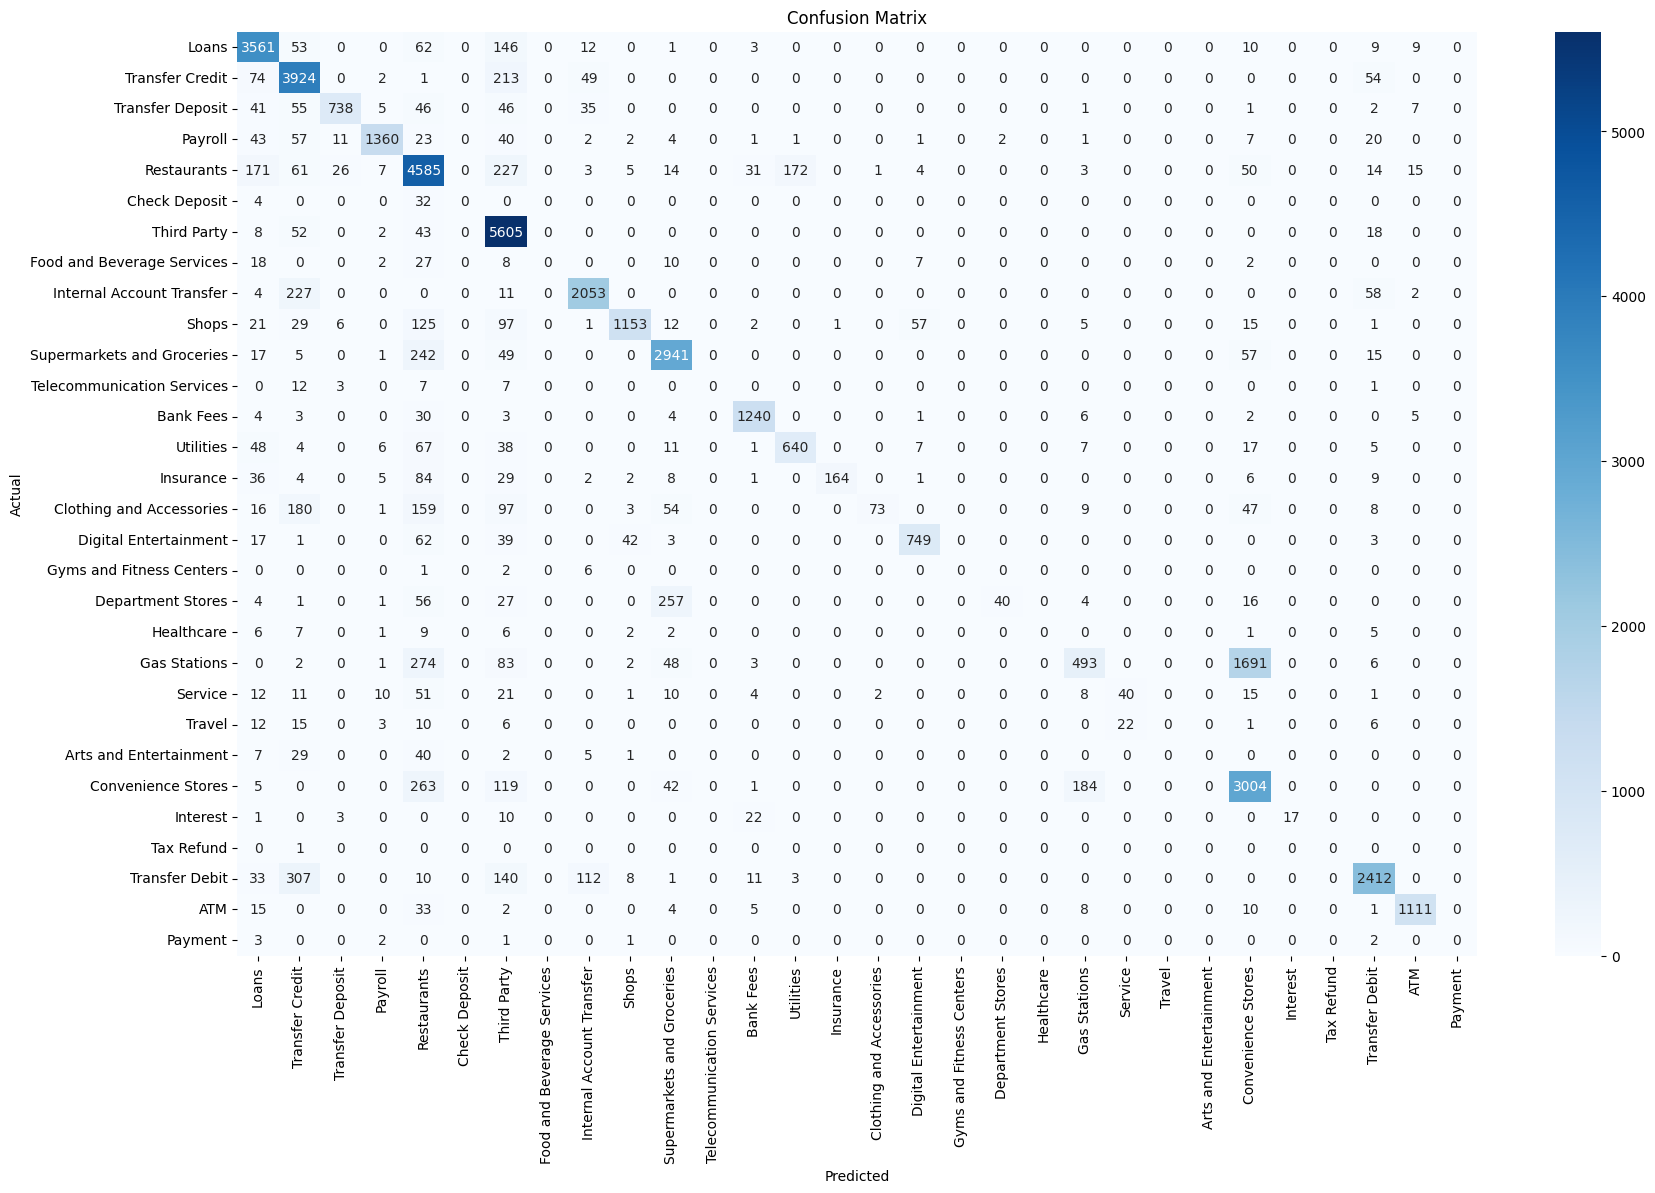

In [121]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=y.unique())

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()